In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt

import scipy as sp
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

In [3]:
#loading real data
p_0130 = sp.sparse.load_npz('../../data/real/20x20x20/run_0130_pDisc.npz')
C_0130 = sp.sparse.load_npz('../../data/real/20x20x20/run_0130_CDisc.npz')
junk_0130 = sp.sparse.load_npz('../../data/real/20x20x20/run_0130_junkDisc.npz')
p_0210 = sp.sparse.load_npz('../../data/real/20x20x20/run_0210_pDisc.npz')
C_0210 = sp.sparse.load_npz('../../data/real/20x20x20/run_0210_CDisc.npz')
junk_0210 = sp.sparse.load_npz('../../data/real/20x20x20/run_0210_junkDisc.npz')

p_real = sp.sparse.vstack([p_0130, p_0210], format='csr')
C_real = sp.sparse.vstack([C_0130, C_0210], format='csr')
junk_real = sp.sparse.vstack([junk_0130, junk_0210], format='csr')

In [4]:
p_real_labels = np.zeros((p_real.shape[0],))
C_real_labels = np.ones((C_real.shape[0],))
junk_real_labels = np.ones((junk_real.shape[0],))

In [5]:
print("Real proton events: " + str(p_real.shape[0]))
print("Real Carbon events: " + str(C_real.shape[0]))
print("Real junk events: " + str(junk_real.shape[0]))

Real proton events: 663
Real Carbon events: 340
Real junk events: 1686


# Predicting proton vs. Carbon (w/ Simulated Noise)

In [6]:
pC_real = sp.sparse.vstack([p_real, C_real], format='csr')
pC_real_labels = np.hstack((p_real_labels, C_real_labels))

In [7]:
pC_train, pC_test, pC_labels_train, pC_labels_test = train_test_split(pC_real, pC_real_labels, test_size=0.25, random_state=42)

In [8]:
print(pC_train.shape)
print(pC_test.shape)

(752, 8000)
(251, 8000)


In [9]:
reg = 0.001
lr_pC = LogisticRegression(C=reg)
lr_pC.fit(pC_train, pC_labels_train)

LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [10]:
#train on simulated + test on simulated 
pC_pred = lr_pC.predict(pC_test)

print("Accuracy: " + str(metrics.accuracy_score(pC_labels_test, pC_pred)))
print(metrics.classification_report(pC_labels_test, pC_pred))
print(metrics.confusion_matrix(pC_labels_test, pC_pred))

Accuracy: 0.848605577689243
             precision    recall  f1-score   support

        0.0       0.86      0.93      0.89       168
        1.0       0.83      0.69      0.75        83

avg / total       0.85      0.85      0.84       251

[[156  12]
 [ 26  57]]


In [11]:
C_vals = [10e-6, 10e-5, 10e-4, 10e-3, 10e-2, 10e-1, 10e0, 10e1, 10e2, 10e3]

precisions_real = []
recalls_real = []
f1s_real = []
accuracies_real = []

for c in C_vals:
    pC_pred = LogisticRegression(C=c).fit(pC_train, pC_labels_train).predict(pC_test)
    
    precisions_real.append(metrics.precision_score(pC_labels_test, pC_pred))
    recalls_real.append(metrics.recall_score(pC_labels_test, pC_pred))
    f1s_real.append(metrics.f1_score(pC_labels_test, pC_pred))
    accuracies_real.append(metrics.accuracy_score(pC_labels_test, pC_pred))
    print("Real Data       C=" + str(c) + " accuracy=" + str(metrics.accuracy_score(pC_labels_test, pC_pred)))

Real Data       C=1e-05 accuracy=0.47808764940239046
Real Data       C=0.0001 accuracy=0.8087649402390438
Real Data       C=0.001 accuracy=0.848605577689243
Real Data       C=0.01 accuracy=0.8366533864541833
Real Data       C=0.1 accuracy=0.8326693227091634
Real Data       C=1.0 accuracy=0.8087649402390438
Real Data       C=10.0 accuracy=0.8087649402390438
Real Data       C=100.0 accuracy=0.8047808764940239
Real Data       C=1000.0 accuracy=0.7888446215139442
Real Data       C=10000.0 accuracy=0.7848605577689243


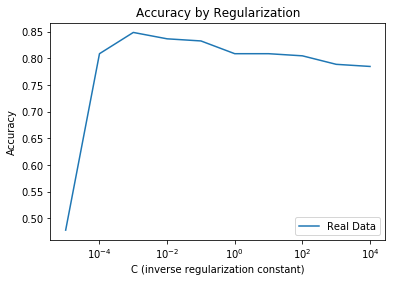

In [12]:
a = np.arange(len(C_vals))

plt.plot(C_vals, accuracies_real)

plt.xscale('log')
        
plt.xlabel('C (inverse regularization constant)')
plt.ylabel('Accuracy')
plt.title('Accuracy by Regularization')
plt.legend(['Real Data'], loc='lower right')

#plt.savefig('../../plots/results/real/LR_pC_accuracyxC.pdf')

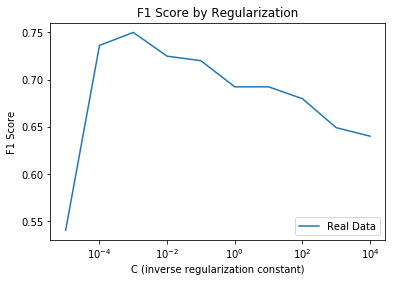

In [13]:
a = np.arange(len(C_vals))

plt.plot(C_vals, f1s_real)

plt.xscale('log')
        
plt.xlabel('C (inverse regularization constant)')
plt.ylabel('F1 Score')
plt.title('F1 Score by Regularization')
plt.legend(['Real Data'], loc='lower right')

#plt.savefig('')

# Predicting proton vs. Carbon + junk (w/ Simulated Noise)

In [14]:
# proton 0s
# Carbon+junk 1s
pCjunk_real = sp.sparse.vstack([p_real, C_real, junk_real], format='csr')
pCjunk_real_labels = np.hstack((p_real_labels, C_real_labels, junk_real_labels))

In [15]:
pCjunk_train, pCjunk_test, pCjunk_labels_train, pCjunk_labels_test = train_test_split(pCjunk_real, pCjunk_real_labels, test_size=0.25, random_state=42)

In [16]:
print(pCjunk_train.shape)
print(pCjunk_test.shape)

(2016, 8000)
(673, 8000)


In [17]:
reg = 0.001
lr_pCjunk = LogisticRegression(C=reg)
lr_pCjunk.fit(pCjunk_train, pCjunk_labels_train)

LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [18]:
#train on simulated + test on simulated 
pCjunk_pred = lr_pCjunk.predict(pCjunk_test)

print("Accuracy: " + str(metrics.accuracy_score(pCjunk_labels_test, pCjunk_pred)))
print(metrics.classification_report(pCjunk_labels_test, pCjunk_pred))
print(metrics.confusion_matrix(pCjunk_labels_test, pCjunk_pred))

Accuracy: 0.8202080237741456
             precision    recall  f1-score   support

        0.0       0.86      0.35      0.50       171
        1.0       0.82      0.98      0.89       502

avg / total       0.83      0.82      0.79       673

[[ 60 111]
 [ 10 492]]


# Predicting proton vs. Carbon vs. junk (w/ Simulated Noise) - **multi-class**

In [19]:
#protons 0
#carbons 1
#junk 2

#create junk 2s labels
junkMC_real_labels = np.full((junk_real_labels.shape[0],), 2)

multi_real = sp.sparse.vstack([p_real, C_real, junk_real], format='csr')
multi_real_labels = np.hstack((p_real_labels, C_real_labels, junkMC_real_labels))

In [20]:
print(multi_real_labels.shape)

(2689,)


In [21]:
multi_train, multi_test, multi_labels_train, multi_labels_test = train_test_split(multi_real, multi_real_labels, test_size=0.25, random_state=42)

In [22]:
reg = 0.001
lr_multi = LogisticRegression(C=reg, multi_class='ovr')
lr_multi.fit(multi_train, multi_labels_train)

LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [23]:
#train on simulated + test on simulated 
multi_pred = lr_multi.predict(multi_test)

print("Accuracy: " + str(metrics.accuracy_score(multi_labels_test, multi_pred)))
print(metrics.classification_report(multi_labels_test, multi_pred))
print(metrics.confusion_matrix(multi_labels_test, multi_pred))

Accuracy: 0.75037147102526
             precision    recall  f1-score   support

        0.0       0.87      0.47      0.61       171
        1.0       0.59      0.31      0.41        83
        2.0       0.74      0.95      0.83       419

avg / total       0.76      0.75      0.73       673

[[ 81   2  88]
 [  7  26  50]
 [  5  16 398]]
